## Fune-tune the System - Decision Tree Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils
from sklearn.pipeline import Pipeline
import numpy as np

import time

In [2]:
start_time = time.time()

In [3]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "DecisionTreeClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

DT_HYPER_PARAM_GRID = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'], # default 'mean'
    'preprocessor__categorical__target_encoder__smooth': ['auto'], # default 'auto'
    'estimator__criterion': ['gini', 'entropy'], # default 'gini'
    'estimator__max_depth': [10, None], # default None
    'estimator__min_samples_split': [2, 5], # default 2
    'estimator__min_samples_leaf': [1, 2], # default 1
    'estimator__max_features': ['sqrt', 'log2', None], # default None
    'estimator__splitter': ['best', 'random'], # default 'best'
}

BS_SAMPLE_NUM = 10

#### 1. Import data and identify attributes

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [6]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [7]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='log_loss',
                                        random_state=42))])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [9]:
best_model = bin_class_utils.tune_hyperparameters(train_cap_x_df, train_y_df, composite_estimator, DT_HYPER_PARAM_GRID)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best estimator hyper parameters:
 {'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__splitter': 'random', 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


#### 4. Evaluate hyperparameter-tuned estimator on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.6831618195376584

Check classification report
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     32369
           1       0.07      0.70      0.13      1156

    accuracy                           0.68     33525
   macro avg       0.53      0.69      0.47     33525
weighted avg       0.95      0.68      0.78     33525


Check confusion matrix
train sample set confusion matrix: 
[[22095 10274]
 [  348   808]]
True Positives =  22095
True Negatives =  808
False Positives(Type I error) =  10274
False Negatives(Type II error) =  348

Check cross validation score

accuracy scores: [0.7054437  0.65816555 0.74526473 0.69366145 0.67829978]
np.mean(scores): 0.6961670395227442
np.std(scores, ddof=1): 0.03265834442855249

precision scores: [0.06180905 0.05601034 0.06482027 0.06114588 0.05989941]
np.mean(scores): 0.06073698914549

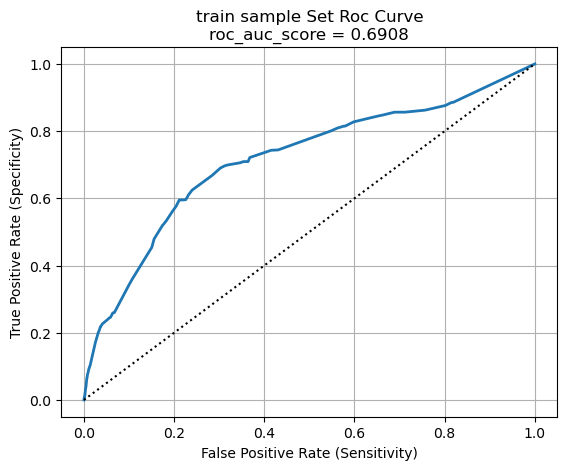


Check Precision-Recall Curve and Average Precision Score


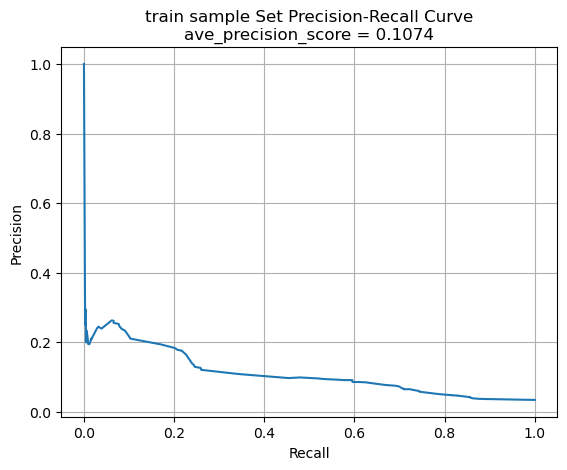

In [10]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train sample", CVS_SCORING_LIST)

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [11]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [12]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [13]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.6722348168476315

Check classification report
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      8092
           1       0.06      0.55      0.10       289

    accuracy                           0.67      8381
   macro avg       0.52      0.62      0.45      8381
weighted avg       0.95      0.67      0.78      8381


Check confusion matrix
validation sample set confusion matrix: 
[[5474 2618]
 [ 129  160]]
True Positives =  5474
True Negatives =  160
False Positives(Type I error) =  2618
False Negatives(Type II error) =  129

Check cross validation score

accuracy scores: [0.80679785 0.63782816 0.77207637 0.6951074  0.88544153]
np.mean(scores): 0.7594502627860013
np.std(scores, ddof=1): 0.09644551732126871

precision scores: [0.04761905 0.05065359 0.04494382 0.05675147 0.10119048]
np.mean(scores): 0.06023

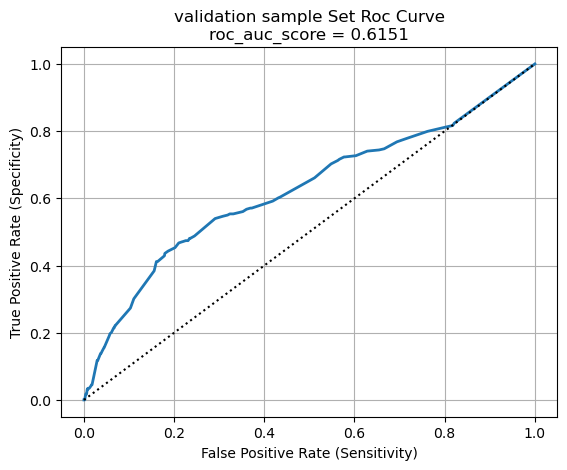


Check Precision-Recall Curve and Average Precision Score


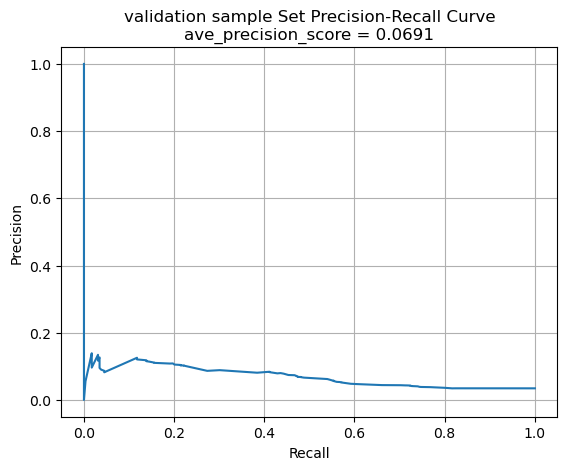

In [14]:
bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation sample", CVS_SCORING_LIST)

#### 6. Check out permutation feature importance

In [15]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,slot_id,0.046395,0.003136
1,average_precision,adv_id,0.026046,0.001305
2,average_precision,age,0.019209,0.001345
3,average_precision,adv_prim_id,0.017570,0.001149
4,average_precision,career,0.015977,0.001555
5,average_precision,app_first_class,0.015808,0.001937
6,average_precision,his_app_size,0.013937,0.002219
7,average_precision,creat_type_cd,0.012051,0.002052
8,average_precision,device_price,0.010513,0.000789
9,average_precision,device_size,0.008164,0.000962


#### 7. Check for false discoveries


**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.065045
randomized_target_sample             0.035322


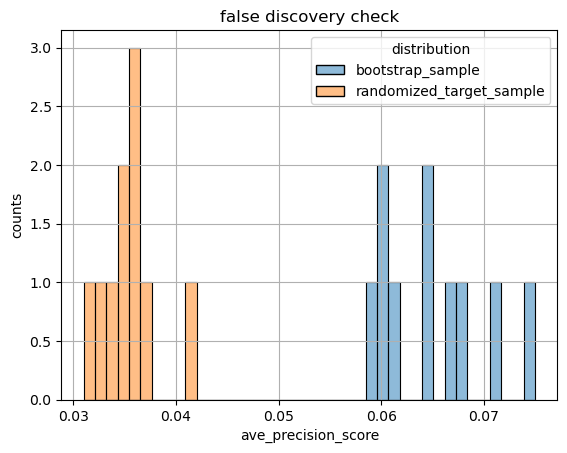


**************************************************
means of the distributions:
                          roc_auc_score
distribution                           
bootstrap_sample               0.614469
randomized_target_sample       0.502807


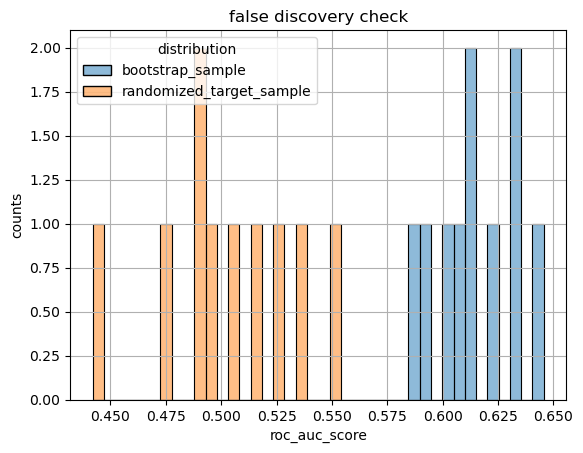

In [16]:
bin_class_utils.avoiding_false_discoveries_class_helper(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    validation_cap_x_df,
    validation_y_df, 
    num_samples=BS_SAMPLE_NUM
)

#### 8. Tune classification threshold for classification - assess threshold list

In [17]:
thresholds = np.arange(0, 1.1, 0.1)

bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,  
    thresholds
)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381


Classification Report at Threshold 0.10:

              precision    recall  f1-score   support

           0       0.96      0.05      0.09      8092
           1       0.03      0.94      0.07       289

    accuracy                           0.08      8381
   macro avg       0.50      0.50      0.08      8381
weighted avg       0.93      0.08      0.09      8381

Classification Report at Threshold 0.20:

              precision    recall  f1-score   support

           0       0.96      0.05      0.09      8092
           1       0.03      0.94      0.07       289

    accuracy                           0.08      8381


/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.96      0.05      0.10      8092
           1       0.03      0.94      0.07       289

    accuracy                           0.08      8381
   macro avg       0.50      0.50      0.08      8381
weighted avg       0.93      0.08      0.10      8381


Classification Report at Threshold 0.50:

              precision    recall  f1-score   support

           0       0.97      0.59      0.74      8092
           1       0.04      0.42      0.06       289

    accuracy                           0.59      8381
   macro avg       0.50      0.50      0.40      8381
weighted avg       0.93      0.59      0.71      8381

Classification Report at Threshold 0.60:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8092
           1       0.03      0.01      0.01       289

    accuracy                           0.96      8381
   macro avg       0.50      0.50      0.49

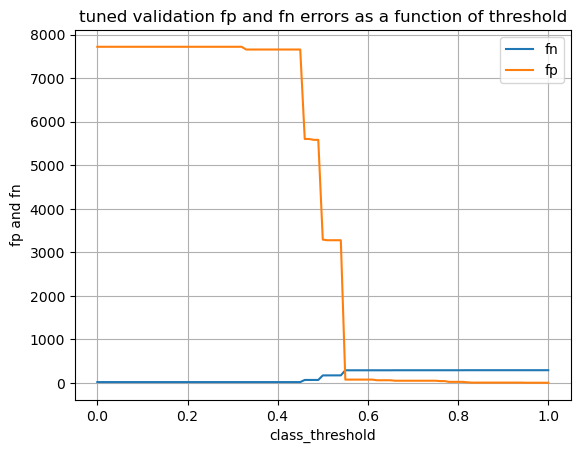

In [18]:
bin_class_utils.plot_errors_to_threshold(
    best_model, 
    validation_cap_x_df, 
    validation_y_df, 
    'tuned validation'
)

#### 9. Higher resolution scan to get the best classification threshold

In [19]:
temp_best_threshold = 0.8

In [20]:
start = temp_best_threshold - 0.05
stop = temp_best_threshold + 0.06
step_size = 0.01

narrow_thresholds = np.arange(start, stop, step_size)
bin_class_utils.print_classification_metrics_at_thresholds(
    validation_cap_x_df, 
    validation_y_df,
    best_model,
    narrow_thresholds
)


Classification Report at Threshold 0.75:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8092
           1       0.02      0.00      0.01       289

    accuracy                           0.96      8381
   macro avg       0.49      0.50      0.49      8381
weighted avg       0.93      0.96      0.95      8381


Classification Report at Threshold 0.76:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.03      0.00      0.01       289

    accuracy                           0.96      8381
   macro avg       0.50      0.50      0.49      8381
weighted avg       0.93      0.96      0.95      8381


Classification Report at Threshold 0.77:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.03      0.00      0.01       289

    accuracy                           0.96      8381

In [21]:
best_threshold = 0.78

#### 10. Evaluate the best classification threshold on validation set

Evaluate the trained estimator performance on best validation set
Check accuracy score
best validation set accuracy score: 0.963130891301754

Check classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8092
           1       0.05      0.00      0.01       289

    accuracy                           0.96      8381
   macro avg       0.51      0.50      0.49      8381
weighted avg       0.93      0.96      0.95      8381


Check confusion matrix
best validation set confusion matrix: 
[[8071   21]
 [ 288    1]]
True Positives =  8071
True Negatives =  1
False Positives(Type I error) =  21
False Negatives(Type II error) =  288

Check cross validation score

accuracy scores: [0.80679785 0.63782816 0.77207637 0.6951074  0.88544153]
np.mean(scores): 0.7594502627860013
np.std(scores, ddof=1): 0.09644551732126871

precision scores: [0.04761905 0.05065359 0.04494382 0.05675147 0.10119048]
np.mean(scores): 0.0602316813031713

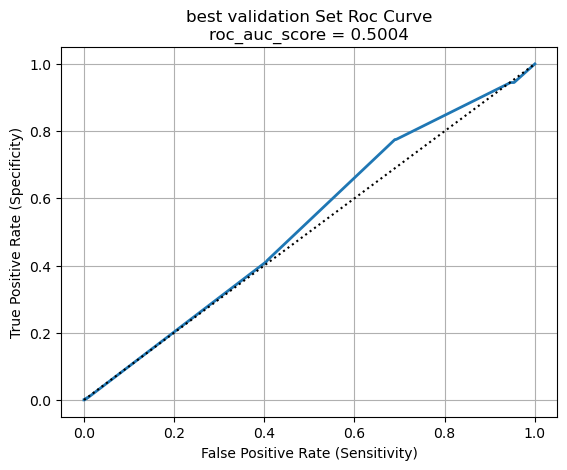


Check Precision-Recall Curve and Average Precision Score


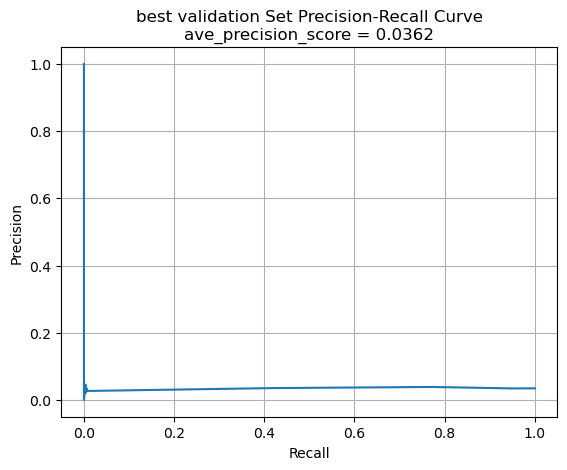

In [22]:
bin_class_utils.eval_class(
    validation_cap_x_df,
    validation_y_df,
    best_model,
    "best validation",
    CVS_SCORING_LIST,
    best_threshold
)

In [23]:
end_time = time.time()
print(f'Script run time: {(end_time - start_time)/60} minutes')

Script run time: 2.3705158988634745 minutes
